## Site Planning

In [1]:
antenna_coordinates = [51.225779846347535, 4.400503131269632]
min_site_coordinates = [51.227090, 4.393261]
max_site_coordinates = [51.227990333375544, 4.389441701586266]

In [2]:
import folium


map = folium.Map(location=antenna_coordinates, zoom_start=15)


antenna_marker = folium.Marker(location=antenna_coordinates, popup="antenna")
min_site_marker = folium.Marker(location=min_site_coordinates, popup="min site")
max_site_marker = folium.Marker(location=max_site_coordinates, popup="max site")

antenna_marker.add_to(map)
min_site_marker.add_to(map)
max_site_marker.add_to(map)

# Display the map
map

In [3]:
from geopy import distance

min_distance_m = distance.distance(antenna_coordinates, min_site_coordinates).m
max_distance_m = distance.distance(antenna_coordinates, max_site_coordinates).m

print(f'min distance: {min_distance_m:.2f} m')
print(f'max distance: {max_distance_m:.2f} m')

min distance: 526.48 m
max distance: 810.88 m


## Requirements

In [4]:
antenna_power_w = 1
bandwidth_hz = 20_000
frequency_hz = 2_000_000

ue_noise_figure_db = 9  # Depends on the design of the amplifier and temperature
ue_antenna_gain_dbi = 0
ue_cable_loss_db = 2

gnb_eirp_dbm = 66

## Free Space Path Loss

In [5]:
import math

def get_fspl_db(distance_m, frequency_hz):
    return 20 * math.log10(distance_m) + 20 * math.log10(frequency_hz) - 147.55

In [6]:
max_fspl_db = get_fspl_db(max_distance_m, frequency_hz)

print(f'max FSPL: {max_fspl_db:.2f} db')

max FSPL: 36.65 db


## Working with dB

```
20 db -> x100 (10^2)
30 db -> x1000 (10^3)

dBm - dBm -> dB
dBm - db  -> dBm
dBm + db  -> dBm
db  + db  -> dB

db - dBm -> nonsense
```

## Signal Power

In [7]:
p_signal_dbm = gnb_eirp_dbm + ue_antenna_gain_dbi - ue_cable_loss_db - max_fspl_db

print(f'signal power: {p_signal_dbm:.2f} dBm')

signal power: 27.35 dBm


## Noise Floor

In [8]:
def get_ktb_noise_dbm(bandwidth_hz, temperature_k=290):
    k = 1.38e-23  # Boltzmann constant
    return 10 * math.log10((k * bandwidth_hz * temperature_k)/1e-3)

ktb_noise_dbm = get_ktb_noise_dbm(10_000)

print(f'KTB noise: {ktb_noise_dbm:.2f} dBm')

KTB noise: -133.98 dBm


In [9]:
ue_noise_floor_dbm = ktb_noise_dbm + ue_noise_figure_db

print(f'UE noise floor: {ue_noise_floor_dbm:.2f} dBm')

UE noise floor: -124.98 dBm


## SNR

In [10]:
snr_db = p_signal_dbm - ue_noise_floor_dbm

print(f'SNR: {snr_db:.2f} dB')

SNR: 152.33 dB


## Shannon Capacity

In [11]:
def convert_db_to_ratio(db):
    return math.pow(10, db / 10)

def get_shannon_capacity_bps(bandwidth_hz, snr):
    return bandwidth_hz * math.log2(1 + snr)

snr = convert_db_to_ratio(snr_db)
channel_capacity_bps = get_shannon_capacity_bps(bandwidth_hz, snr)

channel_capacity_mbps = channel_capacity_bps / 1_000_000

print(f'channel capacity: {channel_capacity_mbps:.2f} Mbps')

channel capacity: 1.01 megabits per second


## Data Rate 4K Stream

Data Rate = Resolution $\times$ Frame Rate $\times$ Color Depth $\times$ Compression Ratio
```
- Data Rate   [bits/seconds]
- Resolution  [pixels/frame]
- Frame Rate  [frames/second]
- Color Depth [bits/pixel]
- Compression Ratio
```

### Sources
- The recommend internet connection speed for playing 4K video from netflix is 15 Mbps
    - https://help.netflix.com/en/node/306

In [17]:
def get_data_rate_bps(resolution, frame_rate, color_depth, compression_ratio):
    return resolution * frame_rate * color_depth * compression_ratio

target_data_rate_bps = get_data_rate_bps(
    resolution=3840 * 2160,
    frame_rate=30,
    color_depth=10,
    compression_ratio=1/100
)

target_data_rate_mbps = target_data_rate_bps / 1_000_000

print(f'target data rate: {target_data_rate_mbps:.2f} Mbps')

target data rate: 24.88 Mbps


## Questions

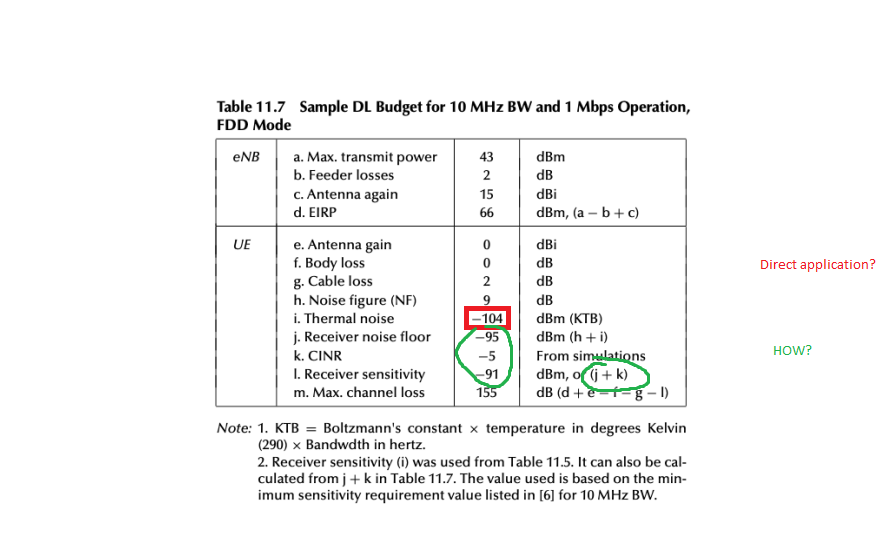